# **NMR chemical shift data as rich nuclear environment features**
Towards continuous atom typing

This allows us to do something quite powerful: predict any of the heads given the other information. Specifically of interest to enzyme design,
- Given an arbitrary point cloud with bond connections, pH, and Temperature, give the **chemical shift (deshielding) of each individual nucleus**


### Imports

In [15]:
import os
import pickle
import numpy as np
import pynmrstar

from tqdm import tqdm

from os.path import exists

### Example

In [16]:
entry = pynmrstar.Entry.from_file(
    "/home/northja/projects/chem_phys/deepNMR/database/bmrb_entries_protein/bmr3/bmr3_3.str",
    convert_data_types=True
)

In [17]:
cs_result_sets = []
tags = ['Comp_index_ID', 'Comp_ID', 'Atom_ID', 'Atom_type', 'Val', 'Val_err']
for chemical_shift_loop in entry.get_loops_by_category("Atom_chem_shift"):
    cs_result_sets.append(chemical_shift_loop.get_tag(tags))
#cs_result_sets

In [18]:
chem_shifts = np.array(cs_result_sets[0])

In [19]:
chem_shifts

array([[1, 'SER', 'HA', 'H', Decimal('4.44'), Decimal('0.01')],
       [1, 'SER', 'HB2', 'H', Decimal('4.11'), Decimal('0.01')],
       [1, 'SER', 'HB3', 'H', Decimal('3.93'), Decimal('0.01')],
       ...,
       [77, 'ALA', 'HB1', 'H', Decimal('1.42'), Decimal('0.01')],
       [77, 'ALA', 'HB2', 'H', Decimal('1.42'), Decimal('0.01')],
       [77, 'ALA', 'HB3', 'H', Decimal('1.42'), Decimal('0.01')]],
      dtype=object)

In [20]:
import pandas as pd

In [23]:
df = pd.DataFrame(
    data=chem_shifts, 
    columns=["res_idx", "res_id", "atom_type", "element", "chem_shift", "cs_error"]
)
df

res_idx res_id atom_type element chem_shift cs_error
0         1    SER        HA       H       4.44     0.01
1         1    SER       HB2       H       4.11     0.01
2         1    SER       HB3       H       3.93     0.01
3         2    THR        HA       H       4.61     0.01
4         2    THR        HB       H        4.8     0.01
..      ...    ...       ...     ...        ...      ...
434      77    ALA         H       H        8.1     0.01
435      77    ALA        HA       H       4.18     0.01
436      77    ALA       HB1       H       1.42     0.01
437      77    ALA       HB2       H       1.42     0.01
438      77    ALA       HB3       H       1.42     0.01

[439 rows x 6 columns]

<AxesSubplot:>

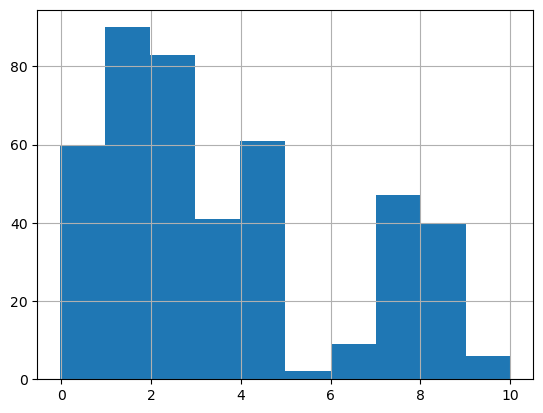

In [22]:
df["chem_shift"].hist()

In [24]:
### merge with PDB structure

In [7]:
len(chem_shifts)

439

In [8]:
condn = []
tags = ['Type', 'Val']
for condition in entry.get_loops_by_category("Sample_condition_variable"):
    condn.append(condition.get_tag(tags))

In [9]:
condn

[[['pH', '6.1'], ['temperature', '303']]]

### Module definitions

In [10]:
def search_files(directory='.', extension=''):
    filelist = []

    extension = extension.lower()
    for dirpath, dirnames, files in os.walk(directory):
        for name in files:
            if extension and name.lower().endswith(extension):
                filelist.append(os.path.join(dirpath, name))
            elif not extension:
                #print(os.path.join(dirpath, name))
                continue
    return filelist

In [11]:
files = search_files(
    directory="/home/northja/projects/chem_phys/deepNMR/database/bmrb_entries_protein/",
    extension=".str"
)
#files

In [12]:
len(files)

14449

In [10]:
def collect_dataset(files:list):
    """
    Collect a dataset from a list of filepaths and save as a pickle archive
    """

    pdb_ids = []
    chemical_shift_tensors = []
    temperatures = []
    pHs = []

    pdb_id = None

    for file in tqdm(files):
        # Setup the entry
        entry = pynmrstar.Entry.from_file(
            file,
            convert_data_types=True
        )

        pdb_id = None

        # Get accession code
        tags = ["Accession_code"]

        pdb_id = [db_loop.get_tag(tags) for db_loop in entry.get_loops_by_category("Assembly_db_link")]
        
        #print(len(pdb_id))
        #assert len(pdb_id) == 1 or 0 # should be a single entry in there
        pdb_ids.append(pdb_id)

        # if the last accession code exists, (just added a PDB code):
        if len(pdb_id) == 1 :
            # Get the next chemical shift tensor
            tags = ['Comp_index_ID', 'Comp_ID', 'Atom_ID', 'Atom_type', 'Val', 'Val_err']        
            cs_result_sets = [chemical_shift_loop.get_tag(tags) for chemical_shift_loop in entry.get_loops_by_category("Atom_chem_shift")]
            
            chem_shifts = np.array(cs_result_sets)
            chemical_shift_tensors.append(chem_shifts)
            
    tensors = [t.squeeze() for t in chemical_shift_tensors]

    file = open("pdb_ids.pkl", 'wb')
    pickle.dump(pdb_ids, file)
    file.close()

    file = open("cs_tensors.pkl", 'wb')
    pickle.dump(chemical_shift_tensors, file)
    file.close() 

    return

In [13]:
file = "cs_tensors.pkl"

def load_dataset(dataset_file:str="cs_tensors.pkl") -> list:
    """
    Loads a dataset from disk if not already stored. Else, loads by processing the data
    """

    if exists(dataset_file):
        file = open(dataset_file, 'rb')
        chemical_shifts = pickle.load(file)

        file = open("pdb_ids.pkl", 'rb')
        pdb_ids = pickle.load(file)
        
        print("SUCCESS:\t Datafile loaded from disk")
        return (chemical_shifts, pdb_ids)
    else:
        print("ERROR:\t Datafile not loaded. Please load manually")
        return None


In [14]:
(chemical_shifts, pdb_ids) = load_dataset()

SUCCESS:	 Datafile loaded from disk


In [33]:
len(pdb_ids)

14449

In [34]:
counts = []

for i in pdb_ids:
    counts.append(len(i))

In [35]:
counts

[0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [50]:
### remove the non-PDB codes
only_pdbs = []

for i in pdb_ids:
    list_j = []
    for j in i:
        for k in j:
            if k is not None and len(k) == 4:
                list_j.append(k)
    only_pdbs.append(list_j)

In [51]:
pdb_list = only_pdbs
pdb_list

[[],
 [],
 [],
 [],
 [],
 [],
 ['2ed0'],
 [],
 [],
 ['1NCS'],
 ['2dba'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['2SCP'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['3TGN'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['5e37'],
 [],
 ['1KY9', '3CS0'],
 ['3A7S', '3IHR', '3RII', '3TB3', '4UEL', '4UEM', '4UF5'],
 ['1l1p', '1w26', '2vrh'],
 [],
 [],
 [],
 ['2KQK', '2L4X'],
 [],
 [],
 [],
 [],
 ['2GZP'],
 [],
 ['1ERQ', '1ERO', '1ERM'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['1DLF', '2DLF'],
 [],
 [],
 [],
 [],
 ['1B3I', '2B3I'],
 [],
 [],
 [],
 [],
 [],
 ['1PET'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['1LKS'],
 ['1L3E'],
 ['2EMB'],
 [],
 ['1fpo', '1r9p'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['2D9U'],
 [],
 ['2DB8'],
 ['7234', '2wf5'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['4D7U'],
 ['1dg0'],
 [],
 [],
 [],
 [],
 ['2yta'],
 [],
 ['1BTA'],
 [],
 [],
 [],
 ['1CE3'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],


In [52]:
l = [len(p) for p in pdb_list]

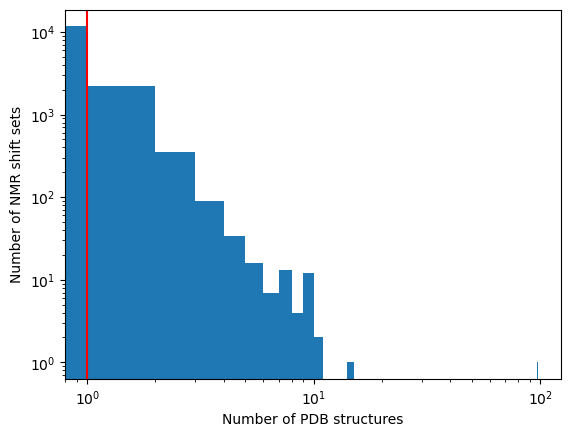

In [63]:
# Plot of pdbs structures per NMR structure
plt.hist(l, bins=98)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of PDB structures')
plt.ylabel('Number of NMR shift sets')
plt.axvline(x=1, c='red')

In [15]:
tensors = [t.squeeze() for t in chemical_shifts]

In [28]:
def one_if_true(i):
    if i:
        return 1
    else:
        return 0


In [64]:
pdb_indices = [one_if_true(p) for p in pdb_list if p]


In [74]:
counts = [len(p) for p in pdb_list]

In [75]:
import numpy as np

In [76]:
cts = np.array(counts)

In [77]:
threes = np.where(cts == 3)
twos = np.where(cts == 2)
ones = np.where(cts == 1)

In [78]:
ones

(array([    6,     9,    10, ..., 14431, 14442, 14447]),)

In [80]:
tensors

[array([[7, 'GLY', 'HA2', 'H', Decimal('3.934'), Decimal('0.030')],
        [7, 'GLY', 'HA3', 'H', Decimal('3.934'), Decimal('0.030')],
        [7, 'GLY', 'C', 'C', Decimal('173.706'), Decimal('0.300')],
        ...,
        [78, 'GLY', 'HA3', 'H', Decimal('3.764'), Decimal('0.030')],
        [78, 'GLY', 'CA', 'C', Decimal('46.249'), Decimal('0.300')],
        [78, 'GLY', 'N', 'N', Decimal('117.013'), Decimal('0.300')]],
       dtype=object),
 array([[1, 'THR', 'HA', 'H', Decimal('3.93'), Decimal('0.05')],
        [1, 'THR', 'HB', 'H', Decimal('4.19'), Decimal('0.05')],
        [1, 'THR', 'HG21', 'H', Decimal('1.33'), Decimal('0.05')],
        ...,
        [59, 'ARG', 'HD2', 'H', Decimal('3.24'), Decimal('0.05')],
        [59, 'ARG', 'HD3', 'H', Decimal('3.24'), Decimal('0.05')],
        [59, 'ARG', 'HE', 'H', Decimal('7.32'), Decimal('0.05')]],
       dtype=object),
 array([[8, 'MET', 'H', 'H', Decimal('8.236'), Decimal('0.030')],
        [8, 'MET', 'HA', 'H', Decimal('4.548'), Decima

In [85]:
len(pdb_list)

14449

In [90]:
pdb2shifts = {k:v for k,v in zip(pdb_list, tensors[ones[0]])}

TypeError: only integer scalar arrays can be converted to a scalar index

array([    6,     9,    10, ..., 14431, 14442, 14447])

In [87]:
tensors[ones]

TypeError: list indices must be integers or slices, not tuple

In [16]:
num_nuclei = 0
for i, model in enumerate(tensors):
    num_nuclei = num_nuclei + len(model)
print(num_nuclei)

2067919


## Brief analysis

In [17]:
l = [p[0] for p in pdb_ids if p]
len(l)

2857

In [18]:
import matplotlib.pyplot as plt

In [19]:
lens = [len(i) for i in l]

(array([2.854e+03, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1. , 10.7, 20.4, 30.1, 39.8, 49.5, 59.2, 68.9, 78.6, 88.3, 98. ]),
 <BarContainer object of 10 artists>)

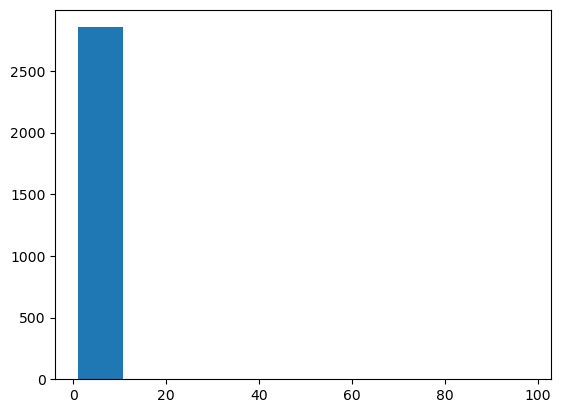

In [20]:
plt.hist(lens)

## Data finagling

In [21]:
tensors[0][0]

array([7, 'GLY', 'HA2', 'H', Decimal('3.934'), Decimal('0.030')],
      dtype=object)

In [43]:
l = [len(p) for p in pdb_list]

In [44]:
l

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


(array([14407.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,    42.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

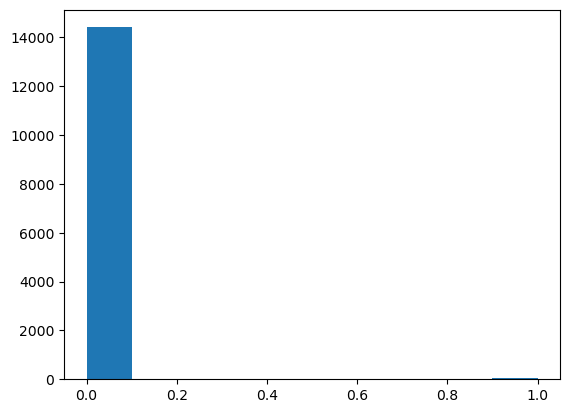

In [45]:
## Get counts of things in each bin
plt.hist(l)

So I guess there's... 42 structures :P

In [46]:
print(pdb_list)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [],

In [23]:
import matplotlib.pyplot as plt


(array([1.1592e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.8530e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

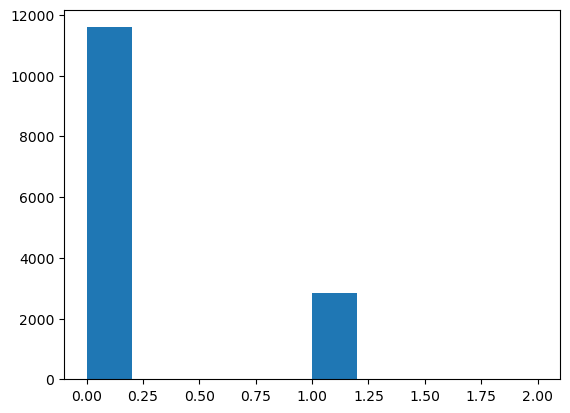

In [24]:
plt.hist(l)

In [25]:
np.where(l != 0 ) 

(array([0]),)

In [ ]:
pdb_ids

In [102]:
counter = 0

structured_pdbs = []

for p in pdb_ids:
    if len(p) is not 0:
        counter = counter + 1
        structured_pdbs.append(p[0])

print(counter)

2857


<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_361/3548097680.py:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(p) is not 0:


In [103]:
structured_pdbs

[['2ed0'],
 ['1NCS'],
 ['2dba'],
 ['2SCP'],
 ['3TGN'],
 ['5e37'],
 ['1KY9', '3CS0'],
 ['3A7S', '3IHR', '3RII', '3TB3', '4UEL', '4UEM', '4UF5'],
 ['1l1p', '1w26', '2vrh'],
 ['2KQK', '2L4X'],
 ['2GZP'],
 ['1ERQ', '1ERO', '1ERM'],
 ['P03322'],
 ['1DLF', '2DLF'],
 ['1B3I', '2B3I'],
 ['1PET'],
 ['1LKS'],
 ['1L3E'],
 ['2EMB'],
 ['15541', '1fpo', '1r9p'],
 ['2D9U'],
 ['2DB8'],
 ['7234', '2wf5'],
 ['Q9ZEQ8'],
 ['26571'],
 ['4D7U'],
 ['1dg0'],
 ['2yta'],
 ['1BTA'],
 ['1CE3'],
 ['5MDI'],
 ['1L1P'],
 ['1KMA'],
 ['2DMQ'],
 ['2YTD'],
 ['1I6Y'],
 ['1x4y'],
 ['1AZK'],
 ['3PDZ'],
 ['2FWU'],
 ['6235', '2N1T'],
 ['1N7T'],
 ['1NFK', '1VKX'],
 ['1V5Q'],
 ['18462',
  '2LT7',
  '4F6M',
  '4F6N',
  '5VMU',
  '5VMV',
  '5VMW',
  '5VMX',
  '5VMY',
  '5VMZ'],
 ['1RML'],
 ['2EOO'],
 ['1JN7'],
 ['1WFJ'],
 ['1K50'],
 ['1lfo'],
 ['1M15'],
 ['1E1A', '1PJX'],
 ['1DKG'],
 ['P44694'],
 ['2OIQ'],
 ['16942', '27493', '2KY9'],
 ['1PVZ'],
 ['1V28'],
 ['1QZP'],
 ['1M4P'],
 ['2A7O'],
 ['2B1W'],
 ['1XU6'],
 ['2yue'],
 ['2d8t'

In [104]:
counts = [len(i) for i in structured_pdbs]

(array([2.854e+03, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1. , 10.7, 20.4, 30.1, 39.8, 49.5, 59.2, 68.9, 78.6, 88.3, 98. ]),
 <BarContainer object of 10 artists>)

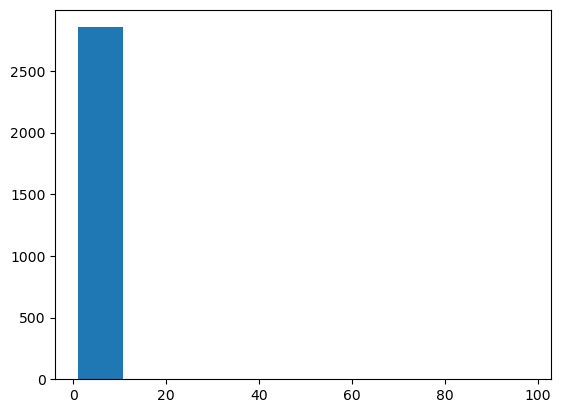

In [105]:
plt.hist(counts)

In [106]:
#[i for i in [j for j in structured_pdbs]]

flat_list = [item for sublist in structured_pdbs for item in sublist]

In [107]:
flat_list

['2ed0',
 '1NCS',
 '2dba',
 '2SCP',
 '3TGN',
 '5e37',
 '1KY9',
 '3CS0',
 '3A7S',
 '3IHR',
 '3RII',
 '3TB3',
 '4UEL',
 '4UEM',
 '4UF5',
 '1l1p',
 '1w26',
 '2vrh',
 '2KQK',
 '2L4X',
 '2GZP',
 '1ERQ',
 '1ERO',
 '1ERM',
 'P03322',
 '1DLF',
 '2DLF',
 '1B3I',
 '2B3I',
 '1PET',
 '1LKS',
 '1L3E',
 '2EMB',
 '15541',
 '1fpo',
 '1r9p',
 '2D9U',
 '2DB8',
 '7234',
 '2wf5',
 'Q9ZEQ8',
 '26571',
 '4D7U',
 '1dg0',
 '2yta',
 '1BTA',
 '1CE3',
 '5MDI',
 '1L1P',
 '1KMA',
 '2DMQ',
 '2YTD',
 '1I6Y',
 '1x4y',
 '1AZK',
 '3PDZ',
 '2FWU',
 '6235',
 '2N1T',
 '1N7T',
 '1NFK',
 '1VKX',
 '1V5Q',
 '18462',
 '2LT7',
 '4F6M',
 '4F6N',
 '5VMU',
 '5VMV',
 '5VMW',
 '5VMX',
 '5VMY',
 '5VMZ',
 '1RML',
 '2EOO',
 '1JN7',
 '1WFJ',
 '1K50',
 '1lfo',
 '1M15',
 '1E1A',
 '1PJX',
 '1DKG',
 'P44694',
 '2OIQ',
 '16942',
 '27493',
 '2KY9',
 '1PVZ',
 '1V28',
 '1QZP',
 '1M4P',
 '2A7O',
 '2B1W',
 '1XU6',
 '2yue',
 '2d8t',
 '1YJV',
 '1P9K',
 '2IGZ',
 '1Q2J',
 '1DUZ',
 '1PLW',
 '1H3Z',
 '1TUC',
 '2JMA',
 '1D2B',
 '1UEA',
 '2e6q',
 '1YEL',

In [108]:
just_pdbs = []

for i in flat_list:
    if isinstance(i, str) and len(i) == 4:
        just_pdbs.append(i)

In [109]:
len(just_pdbs)

3799

## Structural analysis

In [92]:
import urllib

In [93]:
def download_pdb(pdbcode, datadir, downloadurl="https://files.rcsb.org/download/"):
    """
    Downloads a PDB file from the Internet and saves it in a data directory.
    :param pdbcode: The standard PDB ID e.g. '3ICB' or '3icb'
    :param datadir: The directory where the downloaded file will be saved
    :param downloadurl: The base PDB download URL, cf.
        `https://www.rcsb.org/pages/download/http#structures` for details
    :return: the full path to the downloaded PDB file or None if something went wrong
    """
    pdbfn = pdbcode + ".pdb"
    url = downloadurl + pdbfn
    outfnm = os.path.join(datadir, pdbfn)
    try:
        urllib.request.urlretrieve(url, outfnm)
        return outfnm
    except Exception as err:
        print(str(err), file=sys.stderr)
        return None

In [94]:
datadir = "/home/northja/datasets/nmr_corresponding_structures/"

In [112]:
from tqdm import tqdm

In [113]:
for id in tqdm(just_pdbs):
    download_pdb(
        pdbcode=id, 
        datadir=datadir
    )

100%|██████████| 3799/3799 [43:21<00:00,  1.46it/s]
